In [295]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import empyrical
import math
from WindPy import w
%matplotlib inline

In [296]:
w.start()

.ErrorCode=0
.Data=[Already conntected!]

In [372]:
start_date, end_date = '2008-12-01', '2020-10-31'

# 读取数据

In [373]:
theme = pd.read_excel('../data/申万行业分类表.xlsx', sheet_name='六板块分类')

In [374]:
del theme['其他']

In [375]:
mv = pd.read_excel('../data/申万行业分类表.xlsx', sheet_name='申万二级行业市值')

In [376]:
mv['行业名称'] = [x.rstrip('\(申万\)').rstrip('Ⅱ') for x in mv['名称']]
mv = mv.set_index('行业名称')

In [392]:
columns = theme.columns
returns = {}
for col in columns:
    print(col)
    sectors = theme[col].dropna().tolist()
    codes, weights = [], []
    for s in sectors:
        s = s.rstrip('\(申万\)').rstrip(u'Ⅱ')
        if mv.loc[s]['总市值（亿元）'] > 0:
            codes.append(mv.loc[s]['代码'])
            weights.append(mv.loc[s]['总市值（亿元）'])
    weights = np.array(weights)
    weights /= weights.sum()
    data = w.wsd(codes, 'close', start_date, end_date, 'Period=M')
    df = pd.DataFrame(np.array(data.Data).T, index=pd.to_datetime(data.Times), columns=codes)
    df = df.pct_change()
    returns[col] = df.mul(weights, axis=1).sum(axis=1)

金融地产
传统周期
品牌消费
医药健康
先进制造
新兴科技


In [393]:
month_rets = pd.DataFrame(returns)

In [394]:
month_rets.head()

,金融地产,传统周期,品牌消费,医药健康,先进制造,新兴科技
2008-12-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2009-01-23,0.163770,0.143487,0.069153,0.144378,0.161087,0.168761
2009-02-27,0.040850,0.065914,0.104540,0.074056,0.057208,0.042166
2009-03-31,0.194832,0.190357,0.145597,0.126931,0.233769,0.160967
2009-04-30,0.014886,0.050651,0.087883,0.081127,0.077210,0.080313


In [395]:
nav = (1 + month_rets).cumprod()

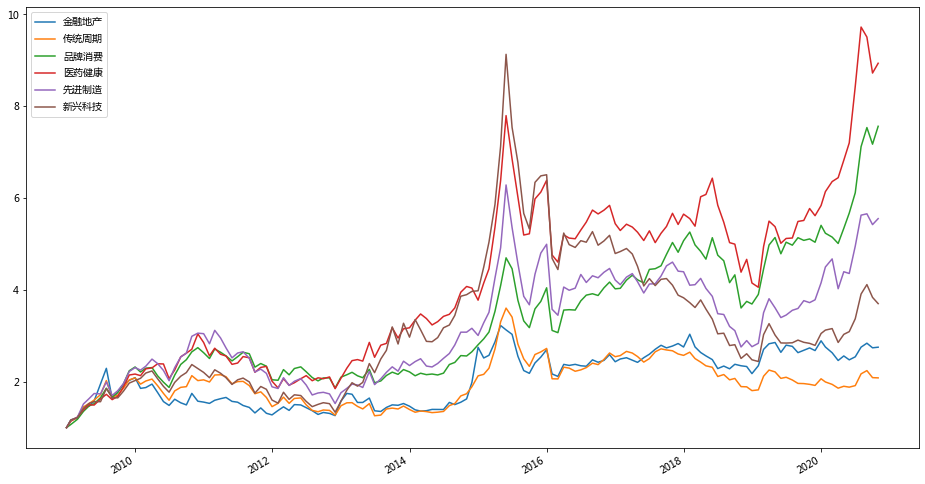

In [396]:
nav.plot(figsize=(16, 9))

# 计算超额收益率

In [398]:
data = w.wsd('000906.SH', 'close', start_date, end_date, "Period=M")

In [399]:
bench = pd.DataFrame(data.Data, index=['中证800'], columns=pd.to_datetime(data.Times))
bench = bench.T

In [400]:
bench_ret = bench.pct_change().fillna(0)

In [401]:
nav = (1 + month_rets.subtract(bench_ret["中证800"], axis=0)).cumprod()

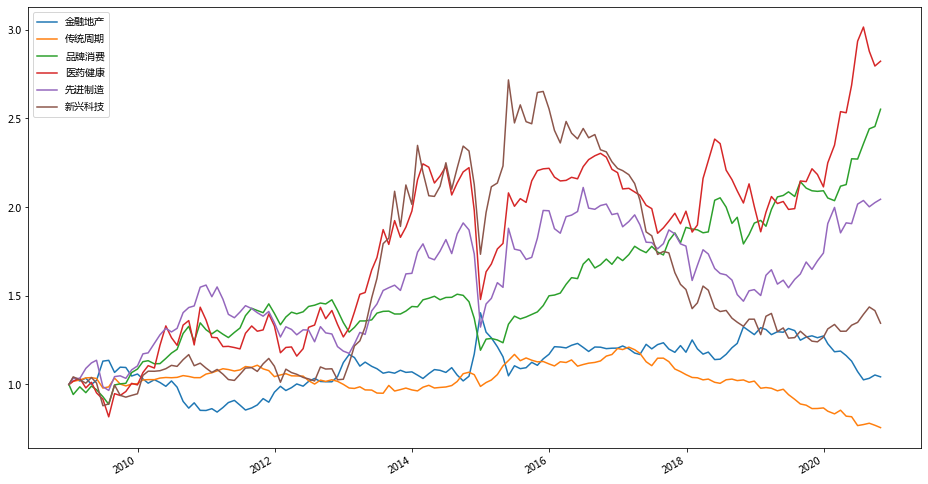

In [402]:
nav.plot(figsize=(16, 9))

# 与宏观指标的关系

### 利率

In [403]:
data = w.edb('S0059749', start_date, end_date)

In [404]:
irate = pd.DataFrame(data.Data, index=['利率'], columns=data.Times)
irate = irate.T
irate.index = pd.to_datetime(irate.index)

In [405]:
irate = irate.resample('M').last()

In [437]:
for col in month_rets.columns:
    print(col, irate["利率"].corr(month_rets[col] - month_rets.mean(axis=1)))

金融地产 0.10098940503176178
传统周期 0.1524136567954566
品牌消费 -0.017445823230112678
医药健康 -0.035271247595330284
先进制造 -0.15652473178508275
新兴科技 -0.07858410385578131


### PPI

In [407]:
data = w.edb('M0001227', start_date, end_date)

In [408]:
ppi = pd.DataFrame(data.Data, index=['ppi'], columns=data.Times)
ppi = ppi.T
ppi.index = pd.to_datetime(ppi.index)

In [409]:
for col in month_rets.columns:
    print(col, ppi["ppi"].corr(month_rets[col] - month_rets.mean(axis=1)))

金融地产 -0.026798015228288976
传统周期 0.06364807741431318
品牌消费 0.08875098128202444
医药健康 -0.0014684612743514269
先进制造 0.007088015660070463
新兴科技 -0.07050002624121723


### PMI

In [410]:
data = w.edb('M0017126', start_date, end_date)

In [411]:
pmi = pd.DataFrame(data.Data, index=['pmi'], columns=data.Times)
pmi = pmi.T
pmi.index = pd.to_datetime(pmi.index)

In [412]:
for col in month_rets.columns:
    print(col, pmi["pmi"].corr(month_rets[col] - month_rets.mean(axis=1)))

金融地产 -0.10170489063544301
传统周期 -0.0017964661936672275
品牌消费 0.1505076996861533
医药健康 0.08982770473277239
先进制造 0.04036603756486906
新兴科技 -0.0811341612816049


### M1/M2

In [413]:
data = w.edb('M0001382,M0001384', start_date, end_date)

In [414]:
money = pd.DataFrame(data.Data, index=['m1', 'm2'], columns=pd.to_datetime(data.Times))
money = money.T

In [438]:
for col in month_rets.columns:
    print(col, money["m1"].corr(month_rets[col] - month_rets.mean(axis=1)))

金融地产 0.08326548580914488
传统周期 -0.019735568896622244
品牌消费 0.07232702954464089
医药健康 -0.04578077737606164
先进制造 -0.001216417789073737
新兴科技 -0.11875993617572224


In [439]:
for col in month_rets.columns:
    print(col, money["m2"].corr(month_rets[col] - month_rets.mean(axis=1)))

金融地产 0.07781176098701136
传统周期 -0.014693724285723464
品牌消费 0.05251249530902213
医药健康 -0.04123170218360386
先进制造 -0.004000728069943437
新兴科技 -0.10184582733595873


### 工业品价格

In [417]:
data = w.wsd('CA.LME', 'close', start_date, end_date)

In [418]:
copper = pd.DataFrame(data.Data, index=['copper'], columns=pd.to_datetime(data.Times))
copper = copper.T

In [419]:
copper_ret = copper.resample('M').last().pct_change()

In [420]:
for col in month_rets.columns:
    print(col, copper_ret['copper'].corr(month_rets[col] - month_rets.mean(axis=1)))

金融地产 -0.10415168235850239
传统周期 -0.019543322075763064
品牌消费 -0.027836681359229978
医药健康 -0.0998362595965966
先进制造 0.19443059926233858
新兴科技 0.14104818888734094


# 打分

In [421]:
scores = pd.DataFrame(columns=month_rets.columns)

In [440]:
row = []
for col in month_rets.columns:
    row.append(irate["利率"].corr(month_rets[col] - month_rets.mean(axis=1)))

In [441]:
scores.loc['利率'] = row

In [458]:
row = []
for col in month_rets.columns:
    row.append(money["m1"].pct_change().corr(month_rets[col] - month_rets.mean(axis=1)))

In [459]:
scores.loc['m1'] = row

In [460]:
row = []
for col in month_rets.columns:
    row.append(ppi["ppi"].corr(month_rets[col] - month_rets.mean(axis=1)))

In [461]:
scores.loc['ppi'] = row

In [462]:
scores

,金融地产,传统周期,品牌消费,医药健康,先进制造,新兴科技
利率,0.100989,0.152414,-0.017446,-0.035271,-0.156525,-0.078584
m1,0.125751,-0.070219,0.096030,0.034539,-0.068713,-0.198635
ppi,-0.026798,0.063648,0.088751,-0.001468,0.007088,-0.070500


### 对于经济周期的判断

In [447]:
economic_sign = 1

In [448]:
sector_scores = scores.mean() * economic_sign

In [449]:
sector_scores

金融地产    0.066648
传统周期    0.048614
品牌消费    0.055779
医药健康   -0.000733
先进制造   -0.072716
新兴科技   -0.115906
dtype: float64

In [450]:
lo, hi = sector_scores.min(), sector_scores.max()

In [451]:
length = (hi - lo) / 4

In [452]:
for i in sector_scores.index:
    sector_scores.loc[i] = math.ceil((sector_scores.loc[i] - lo) / length + -2)

In [453]:
sector_scores = sector_scores.astype(int)

In [454]:
sector_scores

金融地产    2
传统周期    2
品牌消费    2
医药健康    1
先进制造   -1
新兴科技   -2
dtype: int32